In [1]:
import tensorflow as tf 
import numpy as np

import pandas as pd
import math
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [35]:
#LEARNABLE MATRIX MULTIPLICATION INSIDE ATTENTION CORE 

def add_look_ahead_mask(x): 

    len_q, len_k = x.shape[-2:]

    mask = 1 - tf.linalg.band_part(tf.ones((len_q, len_k)), -1, 0)
    mask*= -1e9
    
    return tf.math.add(x,mask) #(batch_size, num_heads, len_q, len_k)

def create_missing_timesteps_mask(q,k):

    len_q = q.shape[1]
    len_k = k.shape[1]

    mask_value=0.

    query_mask_trigger = tf.cast(tf.reduce_any(q != mask_value, axis=2),'float32')
    key_mask_trigger = tf.cast(tf.reduce_any(k != mask_value, axis=2),'float32')

    query_mask_trigger = tf.reshape(query_mask_trigger, (-1,len_q,1))
    key_mask_trigger = tf.reshape(key_mask_trigger, (-1,1,len_k))

    MASK=tf.reshape((tf.matmul(query_mask_trigger,key_mask_trigger)-1)*1e9,shape=(-1,1,len_q,len_k))
    
    return MASK

batch_size, timesteps_q, timesteps_k, input_dim_q, input_dim_k, num_heads, d_attention = 32, 10, 10, 8, 8, 6, 16

#get q,k,v as inputs
q = tf.random.uniform((batch_size, timesteps_q, input_dim_q))
k = tf.random.uniform((batch_size, timesteps_k, input_dim_k))
v = tf.random.uniform((batch_size, timesteps_k, input_dim_k))

#create missing timesteps mask
MASK=create_missing_timesteps_mask(q,k)
print('\n missing timesteps MASK shape: '+str(MASK.shape))

#build the q,k,v weights
q_weights = tf.random.uniform((num_heads,input_dim_q,d_attention))
q_weights = tf.Variable(q_weights, trainable = True)
k_weights = tf.random.uniform((num_heads,input_dim_k,d_attention))
k_weights = tf.Variable(k_weights, trainable = True)
v_weights = tf.random.uniform((num_heads,input_dim_k,d_attention))
v_weights = tf.Variable(v_weights, trainable = True)

#multiply inputs with weights
q = tf.matmul(tf.stack([q]*num_heads,axis=1),q_weights)
k = tf.matmul(tf.stack([k]*num_heads,axis=1),k_weights)
v = tf.matmul(tf.stack([v]*num_heads,axis=1),v_weights)

#multiply q and k and divide by sqrt(d_attention)
attention_logits = tf.matmul(q, k, transpose_b=True)/tf.math.sqrt(tf.cast(d_attention, tf.float32))
print('\n attention logits shape: '+str(attention_logits.shape))

#add look ahead mask 
attention_logits=add_look_ahead_mask(attention_logits)
print('\n attention logits shape after look ahead masking: '+str(attention_logits.shape))

#add missing timesteps mask
attention_logits = tf.math.add(attention_logits,MASK)
print('\n attention logits shape after missing timesteps masking: '+str(attention_logits.shape))

#softmax
attention_weights = tf.nn.softmax(attention_logits, axis=-1)
print('\n attention weights shape: '+str(attention_weights.shape))

#multiply weights and v
attention = tf.matmul(attention_logits, v) #(batch_size, num_heads, timesteps_q, d_attention)
print('\n attention shape: '+str(attention.shape))

conc_attention = tf.reshape(attention, shape=(-1,timesteps_q,d_attention*num_heads))
print('\n concatenate attention shape: '+str(conc_attention.shape))

dense = tf.keras.layers.Dense(input_dim_q)

attention_output = dense(conc_attention)
print('\n attention output shape: '+str(attention_output.shape))





 missing timesteps MASK shape: (32, 1, 10, 10)

 attention logits shape: (32, 6, 10, 10)

 attention logits shape after look ahead masking: (32, 6, 10, 10)

 attention logits shape after missing timesteps masking: (32, 6, 10, 10)

 attention weights shape: (32, 6, 10, 10)

 attention shape: (32, 6, 10, 16)

 concatenate attention shape: (32, 10, 96)

 attention output shape: (32, 10, 8)


## Transformer Classes

In [90]:
class PositionalEncoder:
    
    def __init__(self):
        pass

    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
        return pos * angle_rates

    def positional_encoding(self,position, d_model):
        angle_rads = self.get_angles(np.arange(position)[:, np.newaxis],
                              np.arange(d_model)[np.newaxis, :],
                              d_model)

        # apply sin to even indices in the array; 2i
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

        # apply cos to odd indices in the array; 2i+1
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        pos_encoding = angle_rads[np.newaxis, ...]

        return tf.cast(pos_encoding, dtype=tf.float32)
    
    def encode(self,x):
        
        _, len_seq, d_model = x.shape
        pos_enc=self.positional_encoding(len_seq, d_model)
        
        return pos_enc + x
    

class MultiHeadAttention(tf.keras.layers.Layer):
    
    def __init__(self,*, d_attention, num_heads, input_dim_q, input_dim_k):
        
        super(MultiHeadAttention,self).__init__()
        self.num_heads=num_heads
        self.d_attention=d_attention
        
        init = tf.random_normal_initializer()
        self.q_weights = tf.Variable(initial_value=init(shape=(num_heads, input_dim_q, d_attention), 
                                                        dtype="float32"),trainable=True)
        self.k_weights = tf.Variable(initial_value=init(shape=(num_heads, input_dim_k, d_attention), 
                                                        dtype="float32"),trainable=True)
        self.v_weights = tf.Variable(initial_value=init(shape=(num_heads, input_dim_k, d_attention), 
                                                        dtype="float32"),trainable=True)
        
        self.dense = tf.keras.layers.Dense(input_dim_q)
        
    def call(self,q,k,v, apply_look_ahead_mask, apply_missing_timesteps_mask):
        
        len_q = q.shape[1]
        
        #create missing timesteps mask
        if apply_missing_timesteps_mask:
            MASK=create_missing_timesteps_mask(q,k)
        
        q = tf.matmul(tf.stack([q]*self.num_heads,axis=1),self.q_weights)
        k = tf.matmul(tf.stack([k]*self.num_heads,axis=1),self.k_weights)
        v = tf.matmul(tf.stack([v]*self.num_heads,axis=1),self.v_weights)
        
        #multiply q and k and divide by sqrt(d_attention)
        attention_logits = tf.matmul(q, k, transpose_b=True)/tf.math.sqrt(tf.cast(self.d_attention, tf.float32))
        
        if apply_missing_timesteps_mask:
            attention_logits = tf.math.add(attention_logits,MASK)
        
        if apply_look_ahead_mask:
            attention_logits=self.look_ahead_mask(attention_logits)
        
        #softmax
        attention_weights = tf.nn.softmax(attention_logits, axis=-1)
        
        #multiply weights and v
        attention = tf.matmul(attention_logits, v) #(batch_size, num_heads, len_q, d_attention)
        
        #concatenate
        conc_attention = tf.reshape(attention, shape=(-1,len_q,self.d_attention*self.num_heads))
    
        #pass trough last linear layer
        attention_output = self.dense(conc_attention)
        
        return attention_output
    
    def create_missing_timesteps_mask(self,q,k):

        len_q = q.shape[1]
        len_k = k.shape[1]
        
        mask_value=0.

        query_mask_trigger = tf.cast(tf.reduce_any(q != mask_value, axis=2),'float32')
        key_mask_trigger = tf.cast(tf.reduce_any(k != mask_value, axis=2),'float32')
        
        query_mask_trigger = tf.reshape(query_mask_trigger, (-1,len_q,1))
        key_mask_trigger = tf.reshape(key_mask_trigger, (-1,1,len_k))
        
        MASK=tf.reshape((tf.matmul(query_mask_trigger,key_mask_trigger)-1)*1e9,shape=(-1,1,len_q,len_k))
        return MASK
    
    def add_look_ahead_mask(self,x): 

        len_q, len_k = x.shape[-2:]

        mask = 1 - tf.linalg.band_part(tf.ones((len_q, len_k)), -1, 0)
        mask*= -1e9

        return tf.math.add(x,mask) #(batch_size, num_heads, len_q, len_k)



class EncoderLayer(tf.keras.layers.Layer):
    
    def __init__(self, *, d_attention, num_heads, input_dim_q, input_dim_k, dff, apply_mask, dropout_rate):
        
        super(EncoderLayer, self).__init__()
        
        self.apply_mask=apply_mask
        
        #multihead attention sublayer
        self.mha = MultiHeadAttention(d_attention=d_attention, 
                                      num_heads=num_heads, 
                                      input_dim_q=input_dim_q, 
                                      input_dim_k=input_dim_k)
        
        #ffw neural network sublayer
        self.ffn = tf.keras.Sequential([
                tf.keras.layers.Dense(dff, activation='relu'),  
                tf.keras.layers.Dense(input_dim_q)  
                ])
        
        #normalization sublayers
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        #dropout sublayers(optional)
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x, training):
        #x.shape=(batch_size, seq_len, n_series)
        mha_output = self.mha(x, x, x, apply_look_ahead_mask=False, apply_missing_timesteps_mask=self.apply_mask)  
        mha_output = self.dropout1(mha_output, training=training)
        out1 = self.layernorm1(x + mha_output)  

        ffn_output = self.ffn(out1)  
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  

        return out2
    
class Encoder(tf.keras.layers.Layer):
    
    def __init__(self, *, num_layers, d_attention, num_heads, input_dim_q, input_dim_k, dff, apply_mask, dropout_rate):
        
        super(Encoder, self).__init__()
        self.num_layers = num_layers
        self.pos_encoder = PositionalEncoder()
        apply_mask_list=[False for _ in range(num_layers)] #mask is applied only to the first encoder layer,
                                                            #altough a mechanism for passing the mask to subsequent 
                                                            #could be implemented 
        
        if apply_mask:
            apply_mask_list[0] = apply_mask
            
        self.enc_layers = [
            EncoderLayer(d_attention=d_attention, 
                         num_heads=num_heads, 
                         input_dim_q=input_dim_q, 
                         input_dim_k=input_dim_k, 
                         dff=dff, 
                         apply_mask=apply_mask_list[i], 
                         dropout_rate=dropout_rate) for i in range(num_layers)]
        
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x, training):
        
        x = self.pos_encoder.encode(x)
        x = self.dropout(x, training=training)
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training)

        return x  
    
class Encoder_Only_Transformer(tf.keras.Model):
    
    def __init__(self,*, num_layers, d_attention, num_heads, input_dim_q, input_dim_k, dff, apply_mask, dropout_rate):
        
        super(Encoder_Only_Transformer,self).__init__()
        
        self.encoder = Encoder(num_layers=num_layers, 
                               d_attention=d_attention, 
                               num_heads=num_heads, 
                               input_dim_q=input_dim_q, 
                               input_dim_k=input_dim_k, 
                               dff=dff, 
                               apply_mask=apply_mask, 
                               dropout_rate=dropout_rate)

        self.flatten = tf.keras.layers.Flatten()
        self.dense= tf.keras.layers.Dense(64,activation='relu')
        self.dense2=tf.keras.layers.Dense(16, activation='relu')
        self.dense_out=tf.keras.layers.Dense(1,activation='linear')
        

    def call(self, inp, training):
        
        
        out = self.encoder(inp, training) 
        out = self.flatten(out)
        out = self.dense(out)
        out = self.dense2(out)
        out = self.dense_out(out)
        
        return out
        

## Application

In [44]:
def min_max_scaler(df_train,df_test,columns=None,MAX=1,MIN=0):
    
    if columns is None:
        columns = df_train.columns

    for col in columns:
        maximum = df_train.loc[:,col].max()
        minimum = df_train.loc[:,col].min()
        df_train.loc[:,col]=(MAX-MIN)*(df_train.loc[:,col]-maximum)/(maximum-minimum) + MAX
        df_test.loc[:,col]=(MAX-MIN)*(df_test.loc[:,col]-maximum)/(maximum-minimum) + MAX
        
    return df_train, df_test

def make_data(df_input,df_target,n_previous_days):   
    dates=df_input.index.date
    dates=np.unique(dates)
    
    inputs=[]
    outputs=[]
    
    for i in range(dates.shape[0]-n_previous_days):
        
        date0=dates[i].strftime('%Y-%m-%d')
        date1=dates[i+n_previous_days].strftime('%Y-%m-%d')
        
        date1_open_GHR = date1+ ' 11:00:00'
        date1_close_GHR = date1+ ' 14:00:00'
        
        max_ghr = df_target.loc[date1_open_GHR:date1_close_GHR].max()
        
        if math.isnan(max_ghr):
            pass
        
        else:
            
            outputs.append(max_ghr)
            
            date1_till_9 =  date1 +' 09:00:00'
            in_seq = df_input.loc[date0:date1_till_9].to_numpy()

            inputs.append(in_seq)
        
    return np.stack(inputs), np.stack(outputs).reshape(-1,1)

In [45]:
df = pd.read_csv('3052-Site_Environment-DG_Weather_Station_04-2016_05-2022.csv')
df.Timestamp = df.Timestamp.astype(np.datetime64) #set 'Timestamp' to np.datetime type
df = df.set_index('Timestamp') # set 'Timestamp' column as index
df = df.resample('H').first() #Fill all the missing timesteps with Nan 
df = df.drop(columns=['Hail_Accumulation','Temperature_Probe_1','Temperature_Probe_2','Max_Wind_Speed','Pyranometer_1'])

df=df.loc[(df.index > '2016-05-17 23:00:00')]

unique_dates = np.unique(df.index.date)
split_value=0.8

split_date = unique_dates[int(split_value*unique_dates.shape[0])]
split_date = np.datetime64(split_date)

df_train = df.loc[:(split_date-1).item().strftime('%Y-%m-%d')]
df_test = df.loc[(split_date).item().strftime('%Y-%m-%d'):]

df_train_target=df_train['Global_Horizontal_Radiation'].copy(deep=True)
df_test_target=df_test['Global_Horizontal_Radiation'].copy(deep=True)

In [46]:
df_train_input , df_test_input = min_max_scaler(df_train, df_test)
MASK_VALUE=0.
df_train_input = df_train_input.fillna(MASK_VALUE)
df_test_input = df_test_input.fillna(MASK_VALUE)

In [47]:
inputs_train,outputs_train=make_data(df_train_input,df_train_target,2)
inputs_test,outputs_test=make_data(df_test_input,df_test_target,2)

## Model 

In [91]:

model = Encoder_Only_Transformer(num_layers=4, 
                                 d_attention=32, 
                                 num_heads=3, 
                                 input_dim_q=inputs_train.shape[2], 
                                 input_dim_k=inputs_train.shape[2], 
                                 dff=64, 
                                 apply_mask=True,
                                 dropout_rate=0.1)

In [92]:
model.compile(loss='mse', optimizer='adam')
model(inputs_train[:100,:,:]).shape

TensorShape([100, 1])

In [93]:
%%time
model.fit(inputs_train,outputs_train,epochs=100,batch_size=32)

Epoch 1/100
53/53 [==============================] - 6s 48ms/step - loss: 668585.4375
Epoch 2/100
53/53 [==============================] - 2s 43ms/step - loss: 150962.9062
Epoch 3/100
53/53 [==============================] - 2s 45ms/step - loss: 28369.2109
Epoch 4/100
53/53 [==============================] - 2s 43ms/step - loss: 25011.9668
Epoch 5/100
53/53 [==============================] - 2s 44ms/step - loss: 22941.6211
Epoch 6/100
53/53 [==============================] - 2s 43ms/step - loss: 22636.2012
Epoch 7/100
53/53 [==============================] - 2s 43ms/step - loss: 22827.1406
Epoch 8/100
53/53 [==============================] - 2s 43ms/step - loss: 22662.6953
Epoch 9/100
53/53 [==============================] - 2s 42ms/step - loss: 21546.5918
Epoch 10/100
53/53 [==============================] - 3s 48ms/step - loss: 20295.8145
Epoch 11/100
53/53 [==============================] - 2s 43ms/step - loss: 19414.3691
Epoch 12/100
53/53 [==============================] - 2s 43ms

mae: 59.39327
mse: 10813.313
mape: 7.8044653


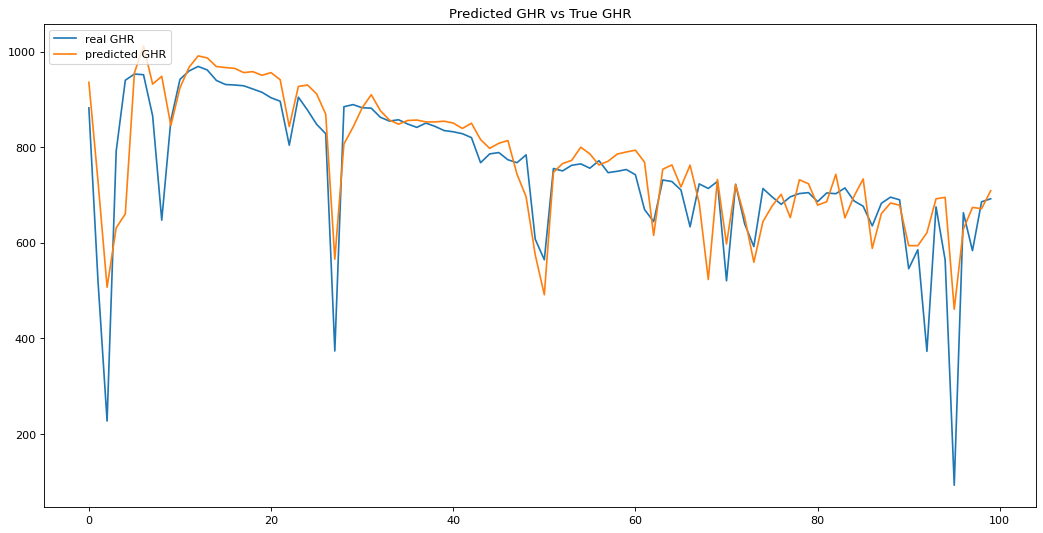

In [94]:
predictions=model.predict(inputs_test)

mse=tf.keras.metrics.MeanSquaredError()
mse.update_state(predictions.reshape(-1,), outputs_test.reshape(-1,))

mae= tf.keras.metrics.MeanAbsoluteError()
mae.update_state(predictions.reshape(-1,), outputs_test.reshape(-1,))

mape = tf.keras.metrics.MeanAbsolutePercentageError()
mape.update_state(predictions.reshape(-1,), outputs_test.reshape(-1,))


print('mae: '  +str(mae.result().numpy())) 
print('mse: '  +str(mse.result().numpy()))
print('mape: '  +str(mape.result().numpy())) 


figure(figsize=(16, 8), dpi=80)
plt.title('Predicted GHR vs True GHR')
plt.plot(outputs_test[:100], label='real GHR')
plt.plot(predictions[:100], label='predicted GHR')
plt.legend(loc="upper left")

plt.show()

### Appendix: Masking Mechanism

In [52]:
#MASKING MECHANISM
batch_size, num_heads, timesteps_query, timesteps_key, d_attention=2,2,12,16,5
mask_value=0.

query=np.ones((batch_size, timesteps_query, d_attention))*3.
key=np.ones((batch_size, timesteps_key, d_attention))*3.

query[0,1,:] = np.zeros((d_attention,))
query[0,3,:] = np.zeros((d_attention,))
query[1,2,:] = np.zeros((d_attention,))
query=tf.constant(query)


key[0,3,:] = np.zeros((d_attention,))
key[1,2,:] = np.zeros((d_attention,))
key=tf.constant(key)

print('\n QUERY \n')
print(query)
print('\n KEY  \n')
print(key)


query_mask_trigger = tf.cast(tf.reduce_any(query != mask_value, axis=2),'float32')
key_mask_trigger = tf.cast(tf.reduce_any(key != mask_value, axis=2),'float32')

print('\n QUERY MASK TRIGGER \n')
print(query_mask_trigger)
print('\n KEY MASK TRIGGER \n')
print(key_mask_trigger)


query_mask_trigger = tf.reshape(query_mask_trigger, (-1,timesteps_query,1))
key_mask_trigger = tf.reshape(key_mask_trigger, (-1,1,timesteps_key))

MASK=tf.reshape((tf.matmul(query_mask_trigger,key_mask_trigger)-1)*1e9,shape=(-1,1,timesteps_query,timesteps_key))

print('\n MASK \n')
print(MASK)


multi_head_att_scores = tf.ones((batch_size, num_heads, timesteps_query, timesteps_key))*2.
multi_head_att_scores_after_masking = tf.math.add(multi_head_att_scores,MASK)

for i in range(batch_size):
    print('\n MASK FOR BATCH ' + str(i) + '\n')
    print(MASK[i,:,:,:])
    
    print('\n SCORES FOR BATCH ' +str(i)+' BEFORE MASKING \n')
    print(multi_head_att_scores[i,:,:,:])
    
    print('\n SCORES FOR BATCH ' +str(i)+' AFTER MASKING \n')
    print(multi_head_att_scores_after_masking[i,:,:,:])


 QUERY 

tf.Tensor(
[[[3. 3. 3. 3. 3.]
  [0. 0. 0. 0. 0.]
  [3. 3. 3. 3. 3.]
  [0. 0. 0. 0. 0.]
  [3. 3. 3. 3. 3.]
  [3. 3. 3. 3. 3.]
  [3. 3. 3. 3. 3.]
  [3. 3. 3. 3. 3.]
  [3. 3. 3. 3. 3.]
  [3. 3. 3. 3. 3.]
  [3. 3. 3. 3. 3.]
  [3. 3. 3. 3. 3.]]

 [[3. 3. 3. 3. 3.]
  [3. 3. 3. 3. 3.]
  [0. 0. 0. 0. 0.]
  [3. 3. 3. 3. 3.]
  [3. 3. 3. 3. 3.]
  [3. 3. 3. 3. 3.]
  [3. 3. 3. 3. 3.]
  [3. 3. 3. 3. 3.]
  [3. 3. 3. 3. 3.]
  [3. 3. 3. 3. 3.]
  [3. 3. 3. 3. 3.]
  [3. 3. 3. 3. 3.]]], shape=(2, 12, 5), dtype=float64)

 KEY  

tf.Tensor(
[[[3. 3. 3. 3. 3.]
  [3. 3. 3. 3. 3.]
  [3. 3. 3. 3. 3.]
  [0. 0. 0. 0. 0.]
  [3. 3. 3. 3. 3.]
  [3. 3. 3. 3. 3.]
  [3. 3. 3. 3. 3.]
  [3. 3. 3. 3. 3.]
  [3. 3. 3. 3. 3.]
  [3. 3. 3. 3. 3.]
  [3. 3. 3. 3. 3.]
  [3. 3. 3. 3. 3.]
  [3. 3. 3. 3. 3.]
  [3. 3. 3. 3. 3.]
  [3. 3. 3. 3. 3.]
  [3. 3. 3. 3. 3.]]

 [[3. 3. 3. 3. 3.]
  [3. 3. 3. 3. 3.]
  [0. 0. 0. 0. 0.]
  [3. 3. 3. 3. 3.]
  [3. 3. 3. 3. 3.]
  [3. 3. 3. 3. 3.]
  [3. 3. 3. 3. 3.]
  [3. 3. 3. 3. 3.]
  [3. 3